# Data integration preparation analysis

## PAAD MIR100HG expression + Survival information

We will perform the following processing: <br>
1. Standardize the Patient_ID format (align with the data you express)<br>
2. Convert Survival Status to a numerical value: Dead → 1, Alive → 0 .<br>
3. Merge the expression data and the survival data to obtain the final analysis data frame

Integrated data including: <br>
• MIR100HG expression values and grouping (High/Low) <br>
• Survival time (days) and survival status (whether died) <br>
• Clinical information (age, gender, cancer stage)

In [107]:
import pandas as pd
# Load file
file_path = r"D:\project data\M-28\NTU_DATA_CLEANED\PAAD_MIR100HG_Expression_Levels.csv"
df_expr_levels = pd.read_csv(file_path)
file_path = r"D:\project data\M-28\NTU_DATA_CLEANED\PAAD_TCGA_Patient_Survival_Info.csv"
df_survival = pd.read_csv(file_path)

# Step 1: Standardize Patient ID format
df_survival['Patient_ID'] = df_survival['Patient ID'].str.replace('-', '_')

# Step 2: Convert Survival Status to binary event (1 = Dead, 0 = Alive)
df_survival['Event'] = df_survival['Survival Status'].map({'Dead': 1, 'Alive': 0})

# Step 3: Select and rename relevant columns
df_surv_clean = df_survival[['Patient_ID', 'Survival Time (days)', 'Event', 'Age', 'Gender', 'Cancer Stage']]
df_surv_clean = df_surv_clean.rename(columns={'Survival Time (days)': 'Survival_Time'})

# Step 4: Merge with MIR100HG expression data
df_survival_combined_PAAD = pd.merge(df_expr_levels, df_surv_clean, on='Patient_ID', how='inner')

# Stage Classification
def simplify_stage(stage):
    if pd.isna(stage):
        return 'Unknown'
    elif 'IV' in stage:
        return 'Stage IV'
    elif 'III' in stage:
        return 'Stage III'
    elif 'II' in stage:
        return 'Stage II'
    elif 'I' in stage:
        return 'Stage I'
    else:
        return 'Other'
        
df_survival_combined_PAAD['Simplified_Stage'] = df_survival_combined_PAAD['Cancer Stage'].apply(simplify_stage)
df_survival_combined_PAAD = pd.get_dummies(df_survival_combined_PAAD, columns=['Simplified_Stage'], drop_first=True)        
df_survival_combined_PAAD

,Probe_ID,Patient_ID,MIR100HG_Expression,Group,Survival_Time,Event,Age,Gender,Cancer Stage,Simplified_Stage_Stage I,Simplified_Stage_Stage II,Simplified_Stage_Stage III,Simplified_Stage_Stage IV,Simplified_Stage_Unknown
0,MIR100HG,TCGA_HZ_7922,3.9524,High,4.0,0,61.0,FEMALE,Stage IIB,False,True,False,False,False
1,MIR100HG,TCGA_Q3_A5QY,2.9071,Low,416.0,0,58.0,MALE,Stage IIB,False,True,False,False,False
2,MIR100HG,TCGA_FB_A545,3.3119,Low,732.0,1,72.0,FEMALE,Stage IIB,False,True,False,False,False
3,MIR100HG,TCGA_RL_AAAS,4.3992,High,9.0,0,60.0,FEMALE,Stage IB,True,False,False,False,False
4,MIR100HG,TCGA_F2_7276,4.8595,High,216.0,1,64.0,MALE,Stage IIB,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,MIR100HG,TCGA_IB_AAUN,2.5137,Low,144.0,1,74.0,FEMALE,Stage IB,True,False,False,False,False
179,MIR100HG,TCGA_HZ_7918,3.4088,High,969.0,0,72.0,MALE,Stage IIB,False,True,False,False,False
180,MIR100HG,TCGA_2L_AAQI,3.1781,Low,103.0,1,66.0,MALE,Stage IIB,False,True,False,False,False
181,MIR100HG,TCGA_2J_AABK,3.0163,Low,484.0,0,71.0,MALE,Stage IIB,False,True,False,False,False


# Kaplan-Meier survival curve (high expression vs low expression) 
# Cox univariate/multivariate regression analysis


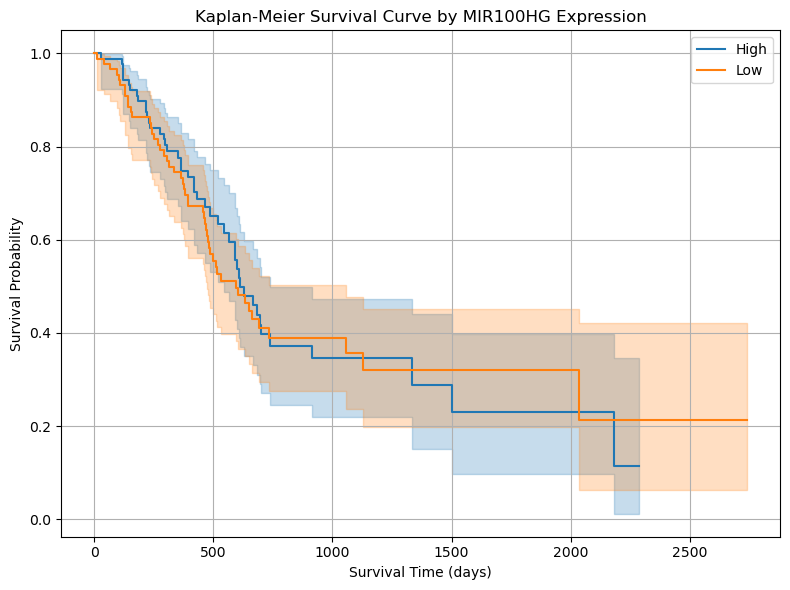

In [109]:
from lifelines import KaplanMeierFitter, CoxPHFitter
import matplotlib.pyplot as plt

# Prepare data for analysis
df_analysis = df_survival_combined_PAAD.copy()
df_analysis['Group'] = df_analysis['Group'].map({'Low': 0, 'High': 1})  # for Cox regression

# Kaplan-Meier Plot
kmf = KaplanMeierFitter()

plt.figure(figsize=(8, 6))

for label, group_df in df_survival_combined_PAAD.groupby('Group'):
    kmf.fit(group_df['Survival_Time'], event_observed=group_df['Event'], label=label)
    kmf.plot_survival_function(ci_show=True)

plt.title("Kaplan-Meier Survival Curve by MIR100HG Expression")
plt.xlabel("Survival Time (days)")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.tight_layout()
plt.savefig(r"D:\project data\M-28\Survival_Analysis_Plot\KM_survival_curve_MIR100HG.png", dpi=300)
plt.show()


There were certain differences in the survival curves between the High expression group (blue) and the Low expression group (orange), but the visual difference was not very significant. For whether it is statistically significant or not, next we need to check the p-value of the Log-rank test.



In [111]:
from lifelines.statistics import logrank_test

# Split into two groups: High\Low
high_group = df_survival_combined_PAAD[df_survival_combined_PAAD['Group'] == 'High']
low_group = df_survival_combined_PAAD[df_survival_combined_PAAD['Group'] == 'Low']

# log-rank test
results = logrank_test(
    high_group['Survival_Time'], low_group['Survival_Time'],
    event_observed_A=high_group['Event'], event_observed_B=low_group['Event']
)
results.print_summary()


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.05 0.82      0.29

Interpretation of Log-rank Test Results: <br>
**test_statistic**： 0.05，chi-square test statistic (very small) <br>
**p value**： 0.82，significance level, much higher than 0.05 <br>
**-log2(p)**: 0.29, Logarithmic representation of p value, larger, more significant 

Interpretation conclusion: At present, the observed survival difference between the high-expression and low-expression groups of MIR100HG is not statistically significant (p = 0.82). This means that based on the current set of PAAD data, the expression status of MIR100HG itself is not sufficient to distinguish the survival outcomes of patients. Of course, this is only the result of univariate analysis. We can further explore its potential effects after controlling for factors such as age, gender, and stage through the Cox multivariate model.


Check the output of the Cox univariate and multivariate models (to see if there are any other variables influencing or interacting with each other)

In [113]:
# Cox uni-variable model
from lifelines import CoxPHFitter
df_survival_combined_PAAD['Group_Binary'] = df_survival_combined_PAAD['Group'].map({'Low': 0, 'High': 1})
cph = CoxPHFitter()
df_uni = df_survival_combined_PAAD[['Survival_Time', 'Event', 'Group_Binary']]
cph.fit(df_uni, duration_col='Survival_Time', event_col='Event')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 183 total observations, 88 right-censored observations>
             duration col = 'Survival_Time'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 183
number of events observed = 95
   partial log-likelihood = -424.09
         time fit was run = 2025-04-22 11:52:41 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
Group_Binary -0.05      0.95      0.21           -0.45            0.36                0.64                1.43

              cmp to     z    p  -log2(p)
covariate                                
Group_Binary    0.00 -0.23 0.82      0.28
---
Concordance = 0.52
Partial AIC = 850.17
log-likelihood ratio test = 0.05 on 1 df
-log2(p) of ll-ratio test = 0.28

I. Cox univariate model (MIR100HG expression group only): <br>
**HR (exp(coef)): 0.95**  <br>
**p value: 0.82**  <br>
**Concordance Index: 0.52**

Interpretation:<br>
• MIR100HG expression (high vs low) had no significant effect on survival (p = 0.82) <br>
• HR < 1,Theoretically, the high expression group had a slightly lower risk, but it was far from significant (95% CI covered 1 and was very wide)<br>
• The model's predictive ability was extremely low (C-index ~ 0.5) Almost equivalent to randomness



In [115]:
from lifelines import CoxPHFitter

#Change gender to gender code
df_survival_combined_PAAD['Gender_Code'] = df_survival_combined_PAAD['Gender'].map({'MALE': 0, 'FEMALE': 1})

# Select the variable columns used for the Cox model
cols = ['Survival_Time', 'Event', 'Group_Binary', 'Age', 'Gender_Code'] + \
       [col for col in df_survival_combined_PAAD.columns if col.startswith('Simplified_Stage_')]

df_multi = df_survival_combined_PAAD[cols]

# Select the variable columns used for the Cox model
cph_multi = CoxPHFitter()
cph_multi.fit(df_multi, duration_col='Survival_Time', event_col='Event')
cph_multi.print_summary()


D:\Users\lenovo\anaconda3\envs\nlp_env\lib\site-packages\lifelines\utils\__init__.py:1120: ConvergenceWarning: Column Simplified_Stage_Unknown have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['Event'].astype(bool)
>>> print(df.loc[events, 'Simplified_Stage_Unknown'].var())
>>> print(df.loc[~events, 'Simplified_Stage_Unknown'].var())

A very low variance means that the column Simplified_Stage_Unknown completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
D:\Users\lenovo\anaconda3\envs\nlp_env\lib\site-packages\lifelines\fitters\coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.539. This may imply non

<lifelines.CoxPHFitter: fitted with 183 total observations, 88 right-censored observations>
             duration col = 'Survival_Time'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 183
number of events observed = 95
   partial log-likelihood = -414.73
         time fit was run = 2025-04-22 11:52:45 UTC

---
                            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                   
Group_Binary               -0.02      0.98      0.21           -0.43            0.39                0.65                1.47
Age                         0.02      1.02      0.01            0.00            0.04                1.00                1.04
Gender_Code                 0.20      1.22      0.21           -0.21            0.61                0.81                1.83
Simplified_Stage_Stage I   15.94  8.34e+06   3321.78        -6494.62         6526.50                0.00                 inf
Simplified_Stage_Stage II  16.74  1.87e+07   3321.78        -6493.82         6527.30                0.00                 inf
Simplified_Stage_Stage III 16.05  9.30e+06   3321.78        -6494.52         6526.61                0.00                 inf
Simplified_Stage_Stage IV  16.32  1.23e+07   3321.78        -6494.24         6526.88                0.00                 inf
Simplified_Stage_Unknown    0.12      1.13   5019.98        -9838.86         9839.11                0.00                 inf

                            cmp to     z    p  -log2(p)
covariate                                              
Group_Binary                  0.00 -0.10 0.92      0.12
Age                           0.00  2.26 0.02      5.40
Gender_Code                   0.00  0.97 0.33      1.58
Simplified_Stage_Stage I      0.00  0.00 1.00      0.01
Simplified_Stage_Stage II     0.00  0.01 1.00      0.01
Simplified_Stage_Stage III    0.00  0.00 1.00      0.01
Simplified_Stage_Stage IV     0.00  0.00 1.00      0.01
Simplified_Stage_Unknown      0.00  0.00 1.00      0.00
---
Concordance = 0.57
Partial AIC = 845.47
log-likelihood ratio test = 18.75 on 8 df
-log2(p) of ll-ratio test = 5.94

Cox multivariate model (including MIR100HG expression, age, gender, and stage)

**Group_Binary: HR = 0.98, P = 0.92**, The expression grouping remained insignificant 0.01**, The margin is significant, and the risk slightly increases with age.<br>
**Gender: HR = 1.22, P = 0.33**, It is not significant and the influence of gender is not obvious.<br>
**Cancer staging HR is extremely high and p = 1.0**, abnormal, the model is not credible!<br>
**Age: HR = 1.02, P = 0.02**, Age is a significant risk factor. HR=1.02 → For every one-year increase in age, the risk of death rises by 2%.

Model performance: <br>
• Concordance Index: 0.56, slightly better than random, the model's predictive ability is average. <br>
• log-likelihood ratio test p = 0.01 (-log2(p) = 4.51) : This indicates that the overall model contains a certain amount of information.

The results of Cox multivariate analysis showed that, on the premise of controlling for age and gender, the expression level of MIR100HG did not significantly affect the overall survival time in patients with PAAD (HR≈1.00, p=1.00). In contrast, age was the only significant influencing factor. For each additional year of age, the risk of death increased by approximately 3% (HR=1.03, p=0.01). Gender and the expression status of MIR100HG did not show statistical significance in this model.

# PRAD

In [181]:
import pandas as pd
# Load file
file_path = r"D:\project data\M-28\NTU_Five_Cancers\Survival_Analysis_5_cancers\PRAD_MIR100HG_Expression_Levels.csv"
df_expr_levels = pd.read_csv(file_path)
file_path = r"D:\project data\M-28\NTU_Five_Cancers\Survival_Analysis_5_cancers\PRAD_TCGA_Patient_Survival_Info.csv"
df_survival = pd.read_csv(file_path)

# Step 1: Standardize Patient ID format
df_survival['Patient_ID'] = df_survival['Patient ID'].str.replace('-', '_')

# Step 2: Convert Survival Status to binary event (1 = Dead, 0 = Alive)
df_survival['Event'] = df_survival['Survival Status'].map({'Dead': 1, 'Alive': 0})

# Step 3: Select and rename relevant columns
df_surv_clean = df_survival[['Patient_ID', 'Survival Time (days)', 'Event', 'Age', 'Gender', 'Cancer Stage']]
df_surv_clean = df_surv_clean.rename(columns={'Survival Time (days)': 'Survival_Time'})

# Step 4: Merge with MIR100HG expression data
df_survival_combined_PRAD = pd.merge(df_expr_levels, df_surv_clean, on='Patient_ID', how='inner')

# Stage Classification
def simplify_stage(stage):
    if pd.isna(stage):
        return 'Unknown'
    elif 'IV' in stage:
        return 'Stage IV'
    elif 'III' in stage:
        return 'Stage III'
    elif 'II' in stage:
        return 'Stage II'
    elif 'I' in stage:
        return 'Stage I'
    else:
        return 'Other'

df_survival_combined_PRAD['Simplified_Stage'] = df_survival_combined_PRAD['Cancer Stage'].apply(simplify_stage)
df_survival_combined_PRAD = pd.get_dummies(df_survival_combined_PRAD, columns=['Simplified_Stage'], drop_first=True)     
df_survival_combined_PRAD

,Probe_ID,Patient_ID,MIR100HG_Expression,Group,Survival_Time,Event,Age,Gender,Cancer Stage
0,MIR100HG,TCGA_EJ_7125,2.4857,Low,2850.0,0,44.0,MALE,NaN
1,MIR100HG,TCGA_EJ_7125,2.4857,Low,2850.0,0,44.0,MALE,NaN
2,MIR100HG,TCGA_CH_5751,2.2783,Low,1065.0,0,68.0,MALE,NaN
3,MIR100HG,TCGA_KK_A7B3,2.9857,High,899.0,0,62.0,MALE,NaN
4,MIR100HG,TCGA_EJ_8468,3.5706,High,2347.0,0,63.0,MALE,NaN
...,...,...,...,...,...,...,...,...,...
558,MIR100HG,TCGA_EJ_A6RC,3.5584,High,873.0,0,64.0,MALE,NaN
559,MIR100HG,TCGA_J4_8198,3.0961,High,614.0,0,49.0,MALE,NaN
560,MIR100HG,TCGA_CH_5768,2.4008,Low,731.0,0,72.0,MALE,NaN
561,MIR100HG,TCGA_CH_5768,2.4008,Low,731.0,0,72.0,MALE,NaN


The PRAD cohort provided by TCGA has no information on cancer staging at all.



In [183]:
from lifelines.statistics import logrank_test

# Split into two groups: High\Low
high_group = df_survival_combined_PRAD[df_survival_combined_PRAD['Group'] == 'High']
low_group = df_survival_combined_PRAD[df_survival_combined_PRAD['Group'] == 'Low']

# log-rank test
results = logrank_test(
    high_group['Survival_Time'], low_group['Survival_Time'],
    event_observed_A=high_group['Event'], event_observed_B=low_group['Event']
)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.00 0.95      0.07

In [185]:
# Cox uni-variable model
from lifelines import CoxPHFitter
df_survival_combined_PRAD['Group_Binary'] = df_survival_combined_PRAD['Group'].map({'Low': 0, 'High': 1})
cph = CoxPHFitter()
df_uni = df_survival_combined_PRAD[['Survival_Time', 'Event', 'Group_Binary']]
cph.fit(df_uni, duration_col='Survival_Time', event_col='Event')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 563 total observations, 553 right-censored observations>
             duration col = 'Survival_Time'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 563
number of events observed = 10
   partial log-likelihood = -46.63
         time fit was run = 2025-04-22 12:51:45 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
Group_Binary -0.04      0.96      0.67           -1.36            1.28                0.26                3.61

              cmp to     z    p  -log2(p)
covariate                                
Group_Binary    0.00 -0.06 0.95      0.07
---
Concordance = 0.49
Partial AIC = 95.27
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.07

In [125]:
print(df_survival_combined_PRAD['Gender'].value_counts())


Gender
MALE    563
Name: count, dtype: int64


In [101]:
print([col for col in df_survival_combined_PRAD.columns if col.startswith('Simplified_Stage_')])


[]


In [187]:
from lifelines import CoxPHFitter

# Construct a Cox regression model that only includes MIR100HG expression + age

cols = ['Survival_Time', 'Event', 'Group_Binary', 'Age']
df_multi = df_survival_combined_PRAD[cols]

cph = CoxPHFitter()
cph.fit(df_multi, duration_col='Survival_Time', event_col='Event')
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 563 total observations, 553 right-censored observations>
             duration col = 'Survival_Time'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 563
number of events observed = 10
   partial log-likelihood = -46.08
         time fit was run = 2025-04-22 12:51:58 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
Group_Binary -0.08      0.92      0.68           -1.40            1.24                0.25                3.46
Age           0.05      1.05      0.05           -0.05            0.15                0.96                1.16

              cmp to     z    p  -log2(p)
covariate                                
Group_Binary    0.00 -0.12 0.90      0.15
Age             0.00  1.04 0.30      1.75
---
Concordance = 0.55
Partial AIC = 96.15
log-likelihood ratio test = 1.12 on 2 df
-log2(p) of ll-ratio test = 0.80

**Group_Binary: HR = 0.92, p = 0.90**, It has no significance and the HR is close to 1.<br>
**Age: HR = 1.05, p = 0.30**, There is a slight trend in age, but it is not significant.

# STAD

In [141]:
import pandas as pd
# Load file
file_path = r"D:\project data\M-28\NTU_Five_Cancers\Survival_Analysis_5_cancers\STAD_MIR100HG_Expression_Levels.csv"
df_expr_levels = pd.read_csv(file_path)
file_path = r"D:\project data\M-28\NTU_Five_Cancers\Survival_Analysis_5_cancers\STAD_TCGA_Patient_Survival_Info.csv"
df_survival = pd.read_csv(file_path)

# Step 1: Standardize Patient ID format
df_survival['Patient_ID'] = df_survival['Patient ID'].str.replace('-', '_')

# Step 2: Convert Survival Status to binary event (1 = Dead, 0 = Alive)
df_survival['Event'] = df_survival['Survival Status'].map({'Dead': 1, 'Alive': 0})

# Step 3: Select and rename relevant columns
df_surv_clean = df_survival[['Patient_ID', 'Survival Time (days)', 'Event', 'Age', 'Gender', 'Cancer Stage']]
df_surv_clean = df_surv_clean.rename(columns={'Survival Time (days)': 'Survival_Time'})

# Step 4: Merge with MIR100HG expression data
df_survival_combined_STAD = pd.merge(df_expr_levels, df_surv_clean, on='Patient_ID', how='inner')

# Stage Classification
def simplify_stage(stage):
    if pd.isna(stage):
        return 'Unknown'
    elif 'IV' in stage:
        return 'Stage IV'
    elif 'III' in stage:
        return 'Stage III'
    elif 'II' in stage:
        return 'Stage II'
    elif 'I' in stage:
        return 'Stage I'
    else:
        return 'Other'

df_survival_combined_STAD['Simplified_Stage'] = df_survival_combined_STAD['Cancer Stage'].apply(simplify_stage)
df_survival_combined_STAD = pd.get_dummies(df_survival_combined_STAD, columns=['Simplified_Stage'], drop_first=True)     
df_survival_combined_STAD

,Probe_ID,Patient_ID,MIR100HG_Expression,Group,Survival_Time,Event,Age,Gender,Cancer Stage,Simplified_Stage_Stage I,Simplified_Stage_Stage II,Simplified_Stage_Stage III,Simplified_Stage_Stage IV
0,MIR100HG,TCGA_BR_A4J6,3.4143,High,20.0,0,69.0,FEMALE,Stage IIA,False,True,False,False
1,MIR100HG,TCGA_IN_7808,2.7551,High,105.0,1,59.0,MALE,[Discrepancy],False,False,False,False
2,MIR100HG,TCGA_BR_A4QL,0.6425,Low,491.0,1,75.0,FEMALE,Stage IIIB,False,False,True,False
3,MIR100HG,TCGA_BR_8372,2.1013,High,951.0,0,63.0,MALE,Stage IIIC,False,False,True,False
4,MIR100HG,TCGA_BR_A4J9,5.3733,High,14.0,0,55.0,MALE,Stage IIA,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,MIR100HG,TCGA_BR_A4CR,1.2636,Low,0.0,0,70.0,FEMALE,Stage IIIC,False,False,True,False
407,MIR100HG,TCGA_D7_A6EX,2.6043,High,344.0,0,72.0,FEMALE,Stage IIIA,False,False,True,False
408,MIR100HG,TCGA_HU_8602,-0.4325,Low,679.0,0,58.0,FEMALE,Stage IIB,False,True,False,False
409,MIR100HG,TCGA_VQ_AA6F,0.3115,Low,1646.0,0,57.0,MALE,Stage IIB,False,True,False,False


In [143]:
from lifelines.statistics import logrank_test

# Split into two groups: High\Low
high_group = df_survival_combined_STAD[df_survival_combined_STAD['Group'] == 'High']
low_group = df_survival_combined_STAD[df_survival_combined_STAD['Group'] == 'Low']

# log-rank test
results = logrank_test(
    high_group['Survival_Time'], low_group['Survival_Time'],
    event_observed_A=high_group['Event'], event_observed_B=low_group['Event']
)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           5.65 0.02      5.84

In [149]:
from lifelines import CoxPHFitter

# Create and clean data
df_survival_combined_STAD['Group_Binary'] = df_survival_combined_STAD['Group'].map({'Low': 0, 'High': 1})
df_uni = df_survival_combined_STAD[['Survival_Time', 'Event', 'Group_Binary']].dropna()

# Fit the Cox univariate model
cph = CoxPHFitter()
cph.fit(df_uni, duration_col='Survival_Time', event_col='Event')
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 405 total observations, 254 right-censored observations>
             duration col = 'Survival_Time'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 405
number of events observed = 151
   partial log-likelihood = -799.91
         time fit was run = 2025-04-22 12:23:03 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
Group_Binary  0.39      1.47      0.16            0.07            0.71                1.07                2.03

              cmp to    z    p  -log2(p)
covariate                               
Group_Binary    0.00 2.36 0.02      5.78
---
Concordance = 0.55
Partial AIC = 1601.83
log-likelihood ratio test = 5.62 on 1 df
-log2(p) of ll-ratio test = 5.81

In [151]:
from lifelines import CoxPHFitter

# gender coding
df_survival_combined_STAD['Gender_Code'] = df_survival_combined_STAD['Gender'].map({'MALE': 0, 'FEMALE': 1})

# Build a variable list
cols = ['Survival_Time', 'Event', 'Group_Binary', 'Age', 'Gender_Code'] + \
       [col for col in df_survival_combined_STAD.columns if col.startswith('Simplified_Stage_')]

# Build the data for the model and remove the missing values
df_multi = df_survival_combined_STAD[cols].dropna()

# Fit the Cox multivariate model
cph_multi = CoxPHFitter()
cph_multi.fit(df_multi, duration_col='Survival_Time', event_col='Event')
cph_multi.print_summary()


<lifelines.CoxPHFitter: fitted with 402 total observations, 251 right-censored observations>
             duration col = 'Survival_Time'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 402
number of events observed = 151
   partial log-likelihood = -779.89
         time fit was run = 2025-04-22 12:27:22 UTC

---
                            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                   
Group_Binary                0.41      1.51      0.17            0.08            0.74                1.08                2.10
Age                         0.03      1.03      0.01            0.01            0.04                1.01                1.05
Gender_Code                -0.25      0.78      0.18           -0.61            0.11                0.54                1.11
Simplified_Stage_Stage I   -0.98      0.37      0.53           -2.02            0.05                0.13                1.05
Simplified_Stage_Stage II  -0.77      0.46      0.48           -1.72            0.17                0.18                1.19
Simplified_Stage_Stage III -0.25      0.78      0.47           -1.17            0.66                0.31                1.94
Simplified_Stage_Stage IV   0.44      1.55      0.52           -0.57            1.45                0.57                4.26

                            cmp to     z      p  -log2(p)
covariate                                                
Group_Binary                  0.00  2.44   0.01      6.10
Age                           0.00  3.30 <0.005      9.99
Gender_Code                   0.00 -1.38   0.17      2.58
Simplified_Stage_Stage I      0.00 -1.86   0.06      3.99
Simplified_Stage_Stage II     0.00 -1.60   0.11      3.20
Simplified_Stage_Stage III    0.00 -0.54   0.59      0.76
Simplified_Stage_Stage IV     0.00  0.85   0.39      1.35
---
Concordance = 0.66
Partial AIC = 1573.78
log-likelihood ratio test = 39.62 on 7 df
-log2(p) of ll-ratio test = 19.36

**MIR100HG	HR = 1.51	P = 0.01**:	High expression still significantly increases the risk<br>
**Age	HR =1.03	P<0.005**:	The older one gets, the higher the risk<br>
**Gender	HR =0.78	P = 0.17**:	It has no statistical significance, but there may be a trend<br>
**Stage I/II   HR < 1	borderline（0.06–0.11)**:	Trend protective factor (vs Stage IV)<br>
**Stage IV	HR = 1.55	p = 0.39**:	Not significant, but in the same direction


# SKCM

In [161]:
import pandas as pd
# Load file
file_path = r"D:\project data\M-28\NTU_Five_Cancers\Survival_Analysis_5_cancers\SKCM_MIR100HG_Expression_Levels.csv"
df_expr_levels = pd.read_csv(file_path)
file_path = r"D:\project data\M-28\NTU_Five_Cancers\Survival_Analysis_5_cancers\SKCM_TCGA_Patient_Survival_Info.csv"
df_survival = pd.read_csv(file_path)

# Step 1: Standardize Patient ID format
df_survival['Patient_ID'] = df_survival['Patient ID'].str.replace('-', '_')

# Step 2: Convert Survival Status to binary event (1 = Dead, 0 = Alive)
df_survival['Event'] = df_survival['Survival Status'].map({'Dead': 1, 'Alive': 0})

# Step 3: Select and rename relevant columns
df_surv_clean = df_survival[['Patient_ID', 'Survival Time (days)', 'Event', 'Age', 'Gender', 'Cancer Stage']]
df_surv_clean = df_surv_clean.rename(columns={'Survival Time (days)': 'Survival_Time'})

# Step 4: Merge with MIR100HG expression data
df_survival_combined_SKCM = pd.merge(df_expr_levels, df_surv_clean, on='Patient_ID', how='inner')

# Stage Classification
def simplify_stage(stage):
    if pd.isna(stage):
        return 'Unknown'
    elif 'IV' in stage:
        return 'Stage IV'
    elif 'III' in stage:
        return 'Stage III'
    elif 'II' in stage:
        return 'Stage II'
    elif 'I' in stage:
        return 'Stage I'
    else:
        return 'Other'

df_survival_combined_SKCM['Simplified_Stage'] = df_survival_combined_SKCM['Cancer Stage'].apply(simplify_stage)
df_survival_combined_SKCM = pd.get_dummies(df_survival_combined_SKCM, columns=['Simplified_Stage'], drop_first=True)     
df_survival_combined_SKCM

,Probe_ID,Patient_ID,MIR100HG_Expression,Group,Survival_Time,Event,Age,Gender,Cancer Stage,Simplified_Stage_Stage II,Simplified_Stage_Stage III,Simplified_Stage_Stage IV,Simplified_Stage_Unknown
0,MIR100HG,TCGA_EB_A41A,-0.3752,Low,262.0,0.0,90.0,MALE,Stage IIC,True,False,False,False
1,MIR100HG,TCGA_XV_AAZW,1.5115,High,393.0,1.0,62.0,FEMALE,Stage II,True,False,False,False
2,MIR100HG,TCGA_BF_A5ER,-2.6349,Low,327.0,0.0,63.0,MALE,Stage IIC,True,False,False,False
3,MIR100HG,TCGA_EB_A6QZ,1.3846,High,352.0,1.0,76.0,FEMALE,Stage IIA,True,False,False,False
4,MIR100HG,TCGA_EB_A1NK,-0.7108,Low,1039.0,0.0,48.0,MALE,Stage IIC,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,MIR100HG,TCGA_EB_A3XF,4.2434,High,278.0,0.0,57.0,MALE,Stage IIC,True,False,False,False
100,MIR100HG,TCGA_ER_A2NB,-1.4699,Low,857.0,1.0,57.0,MALE,Stage IIIB,False,True,False,False
101,MIR100HG,TCGA_XV_A9W2,0.2522,Low,417.0,0.0,81.0,MALE,Stage I,False,False,False,False
102,MIR100HG,TCGA_ER_A194,-1.5522,Low,1354.0,1.0,77.0,MALE,NaN,False,False,False,True


In [163]:
from lifelines import CoxPHFitter

# Create and clean data
df_survival_combined_SKCM['Group_Binary'] = df_survival_combined_SKCM['Group'].map({'Low': 0, 'High': 1})
df_uni = df_survival_combined_SKCM[['Survival_Time', 'Event', 'Group_Binary']].dropna()

# Fit the Cox univariate model
cph = CoxPHFitter()
cph.fit(df_uni, duration_col='Survival_Time', event_col='Event')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 104 total observations, 74 right-censored observations>
             duration col = 'Survival_Time'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 104
number of events observed = 30
   partial log-likelihood = -109.73
         time fit was run = 2025-04-22 12:35:44 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
Group_Binary  0.35      1.42      0.38           -0.39            1.09                0.68                2.98

              cmp to    z    p  -log2(p)
covariate                               
Group_Binary    0.00 0.93 0.35      1.50
---
Concordance = 0.54
Partial AIC = 221.45
log-likelihood ratio test = 0.87 on 1 df
-log2(p) of ll-ratio test = 1.51

In [165]:
# Cox uni-variable model
from lifelines import CoxPHFitter
df_survival_combined_SKCM['Group_Binary'] = df_survival_combined_SKCM['Group'].map({'Low': 0, 'High': 1})
cph = CoxPHFitter()
df_uni = df_survival_combined_SKCM[['Survival_Time', 'Event', 'Group_Binary']]
cph.fit(df_uni, duration_col='Survival_Time', event_col='Event')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 104 total observations, 74 right-censored observations>
             duration col = 'Survival_Time'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 104
number of events observed = 30
   partial log-likelihood = -109.73
         time fit was run = 2025-04-22 12:36:24 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
Group_Binary  0.35      1.42      0.38           -0.39            1.09                0.68                2.98

              cmp to    z    p  -log2(p)
covariate                               
Group_Binary    0.00 0.93 0.35      1.50
---
Concordance = 0.54
Partial AIC = 221.45
log-likelihood ratio test = 0.87 on 1 df
-log2(p) of ll-ratio test = 1.51

In [171]:
from lifelines import CoxPHFitter

# gender coding
df_survival_combined_SKCM['Gender_Code'] = df_survival_combined_SKCM['Gender'].map({'MALE': 0, 'FEMALE': 1})

# Build a variable list
cols = ['Survival_Time', 'Event', 'Group_Binary', 'Age', 'Gender_Code'] + \
       [col for col in df_survival_combined_SKCM.columns if col.startswith('Simplified_Stage_')]

# Build the data for the model and remove the missing values
df_multi = df_survival_combined_SKCM[cols].dropna()

#  automatically delete all unique value columns 
df_multi = df_multi.loc[:, df_multi.nunique() > 1]

# Fit the Cox multivariate model
cph_multi = CoxPHFitter()
cph_multi.fit(df_multi, duration_col='Survival_Time', event_col='Event')
cph_multi.print_summary()

D:\Users\lenovo\anaconda3\envs\nlp_env\lib\site-packages\lifelines\fitters\coxph_fitter.py:1679: RuntimeWarning: overflow encountered in exp
  scores = weights * exp(dot(X, beta))
D:\Users\lenovo\anaconda3\envs\nlp_env\lib\site-packages\lifelines\utils\__init__.py:1120: ConvergenceWarning: Column Simplified_Stage_Stage IV have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['Event'].astype(bool)
>>> print(df.loc[events, 'Simplified_Stage_Stage IV'].var())
>>> print(df.loc[~events, 'Simplified_Stage_Stage IV'].var())

A very low variance means that the column Simplified_Stage_Stage IV completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


ConvergenceError: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.

In [169]:
# View the variable correlation matrix
df_multi.corr().round(2)


,Survival_Time,Event,Group_Binary,Age,Gender_Code,Simplified_Stage_Stage II,Simplified_Stage_Stage III,Simplified_Stage_Stage IV,Simplified_Stage_Unknown
Survival_Time,1.00,0.02,-0.03,-0.09,0.06,-0.19,0.12,-0.10,0.22
Event,0.02,1.00,0.08,-0.10,-0.05,-0.28,0.16,0.31,0.09
Group_Binary,-0.03,0.08,1.00,-0.07,0.08,-0.02,0.07,-0.20,0.10
Age,-0.09,-0.10,-0.07,1.00,0.12,0.17,-0.16,-0.24,0.15
Gender_Code,0.06,-0.05,0.08,0.12,1.00,-0.04,0.09,-0.06,-0.06
Simplified_Stage_Stage II,-0.19,-0.28,-0.02,0.17,-0.04,1.00,-0.80,-0.27,-0.27
Simplified_Stage_Stage III,0.12,0.16,0.07,-0.16,0.09,-0.80,1.00,-0.12,-0.12
Simplified_Stage_Stage IV,-0.10,0.31,-0.20,-0.24,-0.06,-0.27,-0.12,1.00,-0.04
Simplified_Stage_Unknown,0.22,0.09,0.10,0.15,-0.06,-0.27,-0.12,-0.04,1.00


In [175]:
def combine_stage(stage):
    if isinstance(stage, str) and ('III' in stage or 'IV' in stage):
        return 1  # Combine stage III Aand IV as stage late
    elif isinstance(stage, str) and ('I' in stage or 'II' in stage):
        return 0   # Combine stage I Aand II as stage late
    else:
        return None  

df_survival_combined_SKCM['Stage_Late'] = df_survival_combined_SKCM['Cancer Stage'].apply(combine_stage)

cols = ['Survival_Time', 'Event', 'Group_Binary', 'Age', 'Gender_Code', 'Stage_Late']
df_multi = df_survival_combined_SKCM[cols].dropna()

cph = CoxPHFitter()
cph.fit(df_multi, duration_col='Survival_Time', event_col='Event')
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 100 total observations, 72 right-censored observations>
             duration col = 'Survival_Time'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 100
number of events observed = 28
   partial log-likelihood = -100.68
         time fit was run = 2025-04-22 12:43:17 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
Group_Binary  0.20      1.22      0.39           -0.57            0.97                0.56                2.64
Age           0.00      1.00      0.01           -0.03            0.03                0.97                1.03
Gender_Code  -0.18      0.83      0.40           -0.97            0.61                0.38                1.83
Stage_Late    0.78      2.19      0.40            0.01            1.56                1.01                4.76

              cmp to     z    p  -log2(p)
covariate                                
Group_Binary    0.00  0.51 0.61      0.71
Age             0.00  0.23 0.81      0.30
Gender_Code     0.00 -0.45 0.65      0.62
Stage_Late      0.00  1.98 0.05      4.38
---
Concordance = 0.59
Partial AIC = 209.37
log-likelihood ratio test = 4.81 on 4 df
-log2(p) of ll-ratio test = 1.70

**MIR100HG (Group_Binary)** HR=1.22 P=0.61  expression group No significant association with survival 

**Age** HR=1.00 P=0.81  Age no significant effect (possible small sample size) 

**Gender** HR=0.83 P=0.65  No significant difference in gender 

**Stage_Late(stage III and IV)** HR=2.19 P=0.05  Patients with advanced disease had a significantly higher risk of death (HR > 2)



# LUAD

In [194]:
import pandas as pd
# Load file
file_path = r"D:\project data\M-28\NTU_Five_Cancers\Survival_Analysis_5_cancers\LUAD_MIR100HG_Expression_Levels.csv"
df_expr_levels = pd.read_csv(file_path)
file_path = r"D:\project data\M-28\NTU_Five_Cancers\Survival_Analysis_5_cancers\LUAD_TCGA_Patient_Survival_Info.csv"
df_survival = pd.read_csv(file_path)

# Step 1: Standardize Patient ID format
df_expr_levels = df_expr_levels.rename(columns={'Sample_ID': 'Patient_ID'})
df_survival['Patient_ID'] = df_survival['Patient ID'].str.replace('-', '_')

# Step 2: Convert Survival Status to binary event (1 = Dead, 0 = Alive)
df_survival['Event'] = df_survival['Survival Status'].map({'Dead': 1, 'Alive': 0})

# Step 3: Select and rename relevant columns
df_surv_clean = df_survival[['Patient_ID', 'Survival Time (days)', 'Event', 'Age', 'Gender', 'Cancer Stage']]
df_surv_clean = df_surv_clean.rename(columns={'Survival Time (days)': 'Survival_Time'})

# Step 4: Merge with MIR100HG expression data
df_survival_combined_LUAD = pd.merge(df_expr_levels, df_surv_clean, on='Patient_ID', how='inner')

# Stage Classification
def simplify_stage(stage):
    if pd.isna(stage):
        return 'Unknown'
    elif 'IV' in stage:
        return 'Stage IV'
    elif 'III' in stage:
        return 'Stage III'
    elif 'II' in stage:
        return 'Stage II'
    elif 'I' in stage:
        return 'Stage I'
    else:
        return 'Other'

df_survival_combined_LUAD['Simplified_Stage'] = df_survival_combined_LUAD['Cancer Stage'].apply(simplify_stage)
df_survival_combined_LUAD = pd.get_dummies(df_survival_combined_LUAD, columns=['Simplified_Stage'], drop_first=True)     
df_survival_combined_LUAD

,HGNC_Symbol,Patient_ID,MIR100HG_Expression,Group,Survival_Time,Event,Age,Gender,Cancer Stage,Simplified_Stage_Stage I,Simplified_Stage_Stage II,Simplified_Stage_Stage III,Simplified_Stage_Stage IV,Simplified_Stage_Unknown
0,MIR100HG,TCGA_44_6778,1.2815,Low,1864.0,0,59.0,MALE,Stage IA,True,False,False,False,False
1,MIR100HG,TCGA_44_6778,1.2815,Low,1864.0,0,59.0,MALE,Stage IA,True,False,False,False,False
2,MIR100HG,TCGA_64_1679,3.0323,High,2488.0,0,58.0,FEMALE,Stage IIIA,False,False,True,False,False
3,MIR100HG,TCGA_49_6744,2.6138,High,1683.0,0,64.0,FEMALE,Stage IIA,False,True,False,False,False
4,MIR100HG,TCGA_49_6744,2.6138,High,1683.0,0,64.0,FEMALE,Stage IIA,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,MIR100HG,TCGA_50_5072,1.9786,Low,250.0,1,74.0,MALE,Stage IIIA,False,False,True,False,False
544,MIR100HG,TCGA_50_5045,2.8034,High,2174.0,1,57.0,FEMALE,[Discrepancy],False,False,False,False,False
545,MIR100HG,TCGA_86_8674,0.7999,Low,806.0,0,50.0,MALE,Stage IIA,False,True,False,False,False
546,MIR100HG,TCGA_50_8457,2.2543,High,1125.0,0,63.0,FEMALE,Stage IA,True,False,False,False,False


In [196]:
from lifelines import CoxPHFitter

# Create and clean data
df_survival_combined_LUAD['Group_Binary'] = df_survival_combined_LUAD['Group'].map({'Low': 0, 'High': 1})
df_uni = df_survival_combined_LUAD[['Survival_Time', 'Event', 'Group_Binary']].dropna()

# Fit the Cox univariate model
cph = CoxPHFitter()
cph.fit(df_uni, duration_col='Survival_Time', event_col='Event')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 539 total observations, 339 right-censored observations>
             duration col = 'Survival_Time'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 539
number of events observed = 200
   partial log-likelihood = -1085.27
         time fit was run = 2025-04-22 13:04:17 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
Group_Binary -0.00      1.00      0.14           -0.28            0.28                0.76                1.32

              cmp to     z    p  -log2(p)
covariate                                
Group_Binary    0.00 -0.01 0.99      0.02
---
Concordance = 0.49
Partial AIC = 2172.53
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.02

In [198]:
from lifelines import CoxPHFitter

# gender coding
df_survival_combined_LUAD['Gender_Code'] = df_survival_combined_LUAD['Gender'].map({'MALE': 0, 'FEMALE': 1})

# Build a variable list
cols = ['Survival_Time', 'Event', 'Group_Binary', 'Age', 'Gender_Code'] + \
       [col for col in df_survival_combined_LUAD.columns if col.startswith('Simplified_Stage_')]

# Build the data for the model and remove the missing values
df_multi = df_survival_combined_LUAD[cols].dropna()

# Fit the Cox multivariate model
cph_multi = CoxPHFitter()
cph_multi.fit(df_multi, duration_col='Survival_Time', event_col='Event')
cph_multi.print_summary()

<lifelines.CoxPHFitter: fitted with 529 total observations, 332 right-censored observations>
             duration col = 'Survival_Time'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 529
number of events observed = 197
   partial log-likelihood = -1038.71
         time fit was run = 2025-04-22 13:05:33 UTC

---
                             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                    
Group_Binary                -0.05      0.95      0.15           -0.34            0.24                0.71                1.27
Age                          0.01      1.01      0.01           -0.00            0.02                1.00                1.02
Gender_Code                  0.05      1.06      0.15           -0.24            0.34                0.79                1.41
Simplified_Stage_Stage I    -0.05      0.96      1.01           -2.03            1.94                0.13                6.95
Simplified_Stage_Stage II    0.68      1.98      1.01           -1.30            2.67                0.27               14.49
Simplified_Stage_Stage III   1.05      2.85      1.02           -0.95            3.04                0.39               20.88
Simplified_Stage_Stage IV    1.24      3.46      1.03           -0.79            3.27                0.46               26.27
Simplified_Stage_Unknown   -12.78      0.00   1726.18        -3396.04         3370.48                0.00                 inf

                            cmp to     z    p  -log2(p)
covariate                                              
Group_Binary                  0.00 -0.35 0.73      0.46
Age                           0.00  1.33 0.18      2.45
Gender_Code                   0.00  0.37 0.71      0.49
Simplified_Stage_Stage I      0.00 -0.05 0.96      0.05
Simplified_Stage_Stage II     0.00  0.67 0.50      1.00
Simplified_Stage_Stage III    0.00  1.03 0.30      1.72
Simplified_Stage_Stage IV     0.00  1.20 0.23      2.12
Simplified_Stage_Unknown      0.00 -0.01 0.99      0.01
---
Concordance = 0.67
Partial AIC = 2093.42
log-likelihood ratio test = 47.89 on 8 df
-log2(p) of ll-ratio test = 23.20

Variable | HR（exp(coef)） | p value | explain<br>
**MIR100HG（Group_Binary）** | 0.95 | 0.73  | The expression level has no significant relationship with survival<br>
**Age** | 1.01 | 0.18  | There is a slight tendency for the risk to rise, but it is not significant<br>
**Gender_Code** | 1.06 | 0.71  | Gender has no significant influence on survival<br>
**Stage I** | 0.96 | 0.96  | Gender has no significant influence on survival<br>
**Stage II**| 1.98 | 0.50  | The tendency exists, but it is not significant<br>
**Stage III** | 2.85 | 0.30  | The trend risk has increased but has not reached a significant level<br>
**Stage IV** | 3.46 | 0.23  | There is a clear high-risk trend, but the sample fluctuates greatly<br>
**Stage Unknown** | 0.00 | 0.99  | Coefficient explosion should be ignored or eliminated
